### Student Name: <span style="color:cyan">Karen Kuruvilla Joseph</span>
### Student ID: <span style="color:cyan">24201111</span>

<span style="color:lime">This code executes to the end without an error.</span>

Sources:
* PyTorch tutorial on [DQN](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html#reinforcement-learning-dqn-tutorial)
* GitHub : [Jack-Sandberg/DQN](https://github.com/Jack-Sandberg/DQN/blob/master/DQN.py)
* GitHub : [GiannisMitr/DQN-Atari-Breakout](https://github.com/GiannisMitr/DQN-Atari-Breakout/blob/master/dqn_atari_breakout.ipynb)


### Objective:
To implement a Reinforcement Learning (RL) agent using a Deep Q Network (DQN) applied to the game of Atari in the OpenAI Gym environment.

### Imports & Initial Setup

In [1]:
import os
import random
import sys

from collections import namedtuple, deque, Counter
from itertools import count
from typing import Any, Union, SupportsFloat

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

In [2]:
assert sys.version_info >= (3,10)

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython.display import Video

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Python Version: {sys.version.split()[0]}")
print(f"Device: {device.type}")
if device.type == 'cuda':
 print(F"GPU Name: {torch.cuda.get_device_name(0)}")
 torch.backends.cudnn.benchmark = True

Python Version: 3.10.17
Device: cuda
GPU Name: NVIDIA GeForce RTX 3050 Laptop GPU


In [3]:
SEED = 42

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

### 1. Why Reinforcement Learning is the ML paradigm of choice for this task?

Reinforcement Learning (RL) is the most appropriate machine learning paradigm for training an Atari game agent because it is designed to solve problems where an agent interacts with an environment and learns through trial and error. In Atari games, there is no predefined set of labels or explicit supervision. The agent must take actions based on the current state of the game and receive feedback in the form of rewards or penalties. RL algorithms like DQN are specifically built to optimize long-term cumulative rewards in such dynamic environments, making them well-suited to handle the complex, sequential decision-making required in Atari games.

### 2. Environment

All information is taken from the [Gymnasium documentation](https://ale.farama.org/environments/breakout/) on the Breakout Atari environment.  

##### a. The Atari game selected:

The selected Atari game for this task is _**`ALE/Breakout-v5`**_. In this game, the agent controls a paddle to bounce a ball and break bricks at the top of the screen. The objective is to clear all the bricks while avoiding the ball falling below the paddle. You have five lives.

##### b. The inputs received from the Gym environment:

* State (Observation):The state is represented by the game screen, which is a 210x160x3 pixel image (RGB). This image provides the current visual state of the game. It can also be observed by the grayscale version of the image, which has dimensions (210, 160).

* Action Space: The action space is discrete with 4 possible actions:

    |Value|Meaning|Value|Meaning|
    |-----|-------|-----|-------|
    |`0`|`NOOP`|`1`|`FIRE`|
    |`2`|`RIGHT`|`3`|`LEFT`|

* Rewards: Points are scored by destroying bricks in the wall. There are six rows of bricks.  The color of a brick determines the
points you score when you hit it with your ball(source: [AtariAge documentation](https://atariage.com/manual_html_page.php?SoftwareID=889)).

    |Brick Colour|Points|Brick Colour|Points|Brick Colour|Points|
    |------------|------|------------|------|------------|------|
    |Red|7|Orange|7|Yellow|4|
    |Green|4|Aqua|1|Blue|1|

##### c. The control settings for the joystick:

These actions are interpreted by ALE (Arcade Learning Environment) as follows:

|Action|Description|
|-----|-------|
|`NOOP`|No operation, do nothing.|
|`FIRE`|Press the fire button without updating the joystick position|
|`RIGHT`|Apply a Δ-movement rightward on the joystick|
|`LEFT`|Apply a Δ-movement leftward on the joystick|

In [4]:
import gymnasium as gym
from gymnasium.wrappers import AtariPreprocessing, FrameStackObservation, RecordVideo
import ale_py

assert gym.__version__ == '1.1.1'

##### Configure classes for DeepMind-style Atari
Reference: [stable-baselines3 atari wrapper](https://github.com/DLR-RM/stable-baselines3/blob/master/stable_baselines3/common/atari_wrappers.py)

In [5]:
AtariResetReturn = tuple[np.ndarray, dict[str, Any]]
AtariStepReturn = tuple[np.ndarray, SupportsFloat, bool, bool, dict[str, Any]]

class FireResetEnv(gym.Wrapper[np.ndarray, int, np.ndarray, int]):
    """
    Take action on reset for environments that are fixed until firing.

    :param env: Environment to wrap
    """

    def __init__(self, env: gym.Env) -> None:
        super().__init__(env)
        assert env.unwrapped.get_action_meanings()[1] == "FIRE"  # type: ignore[attr-defined]
        assert len(env.unwrapped.get_action_meanings()) >= 3  # type: ignore[attr-defined]

    def reset(self, **kwargs) -> AtariResetReturn:
        self.env.reset(**kwargs)
        obs, _, terminated, truncated, _ = self.env.step(1)
        if terminated or truncated:
            self.env.reset(**kwargs)
        obs, _, terminated, truncated, _ = self.env.step(2)
        if terminated or truncated:
            self.env.reset(**kwargs)
        return obs, {}


class EpisodicLifeEnv(gym.Wrapper[np.ndarray, int, np.ndarray, int]):
    """
    Make end-of-life == end-of-episode, but only reset on true game over.
    Done by DeepMind for the DQN and co. since it helps value estimation.

    :param env: Environment to wrap
    """

    def __init__(self, env: gym.Env) -> None:
        super().__init__(env)
        self.lives = 0
        self.was_real_done = True

    def step(self, action: int) -> AtariStepReturn:
        obs, reward, terminated, truncated, info = self.env.step(action)
        self.was_real_done = terminated or truncated
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()  # type: ignore[attr-defined]
        if 0 < lives < self.lives:
            # for Qbert sometimes we stay in lives == 0 condition for a few frames
            # so its important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            terminated = True
        self.lives = lives
        return obs, reward, terminated, truncated, info

    def reset(self, **kwargs) -> AtariResetReturn:
        """
        Calls the Gym environment reset, only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.

        :param kwargs: Extra keywords passed to env.reset() call
        :return: the first observation of the environment
        """
        if self.was_real_done:
            obs, info = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, terminated, truncated, info = self.env.step(0)

            # The no-op step can lead to a game over, so we need to check it again
            # to see if we should reset the environment and avoid the
            # monitor.py `RuntimeError: Tried to step environment that needs reset`
            if terminated or truncated:
                obs, info = self.env.reset(**kwargs)
        self.lives = self.env.unwrapped.ale.lives()  # type: ignore[attr-defined]
        return obs, info

In [7]:
gym.register_envs(ale_py)

env_id = "PongNoFrameskip-v4"
video_name_prefix = "Pong-v4-d3qn-PER"

env = gym.make(env_id, render_mode="rgb_array")

# For visualization, save the original RGB frame
env.reset(seed=SEED)
original_rgb = env.render()

env = EpisodicLifeEnv(env)
if 'FIRE' in env.unwrapped.get_action_meanings():
    env = FireResetEnv(env)

env = AtariPreprocessing(
    env,
    noop_max=30,
    frame_skip=4,
    screen_size=84,
    grayscale_obs=True,
    scale_obs=True
    )
env = FrameStackObservation(env, stack_size=4)
env = RecordVideo(
    env, 
    video_folder="./video/", 
    episode_trigger=lambda t: t >= 300 and t % 25 == 0,
    name_prefix = video_name_prefix,
    disable_logger=True
    )

/home/kj/MSc/CS6482_Deep_RL/Assignments/rl-dqn-atari-breakout/venv/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /home/kj/MSc/CS6482_Deep_RL/Assignments/rl-dqn-atari-breakout/Pong/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [8]:
obs, _ = env.reset(seed=SEED)
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}")
print(f"Sample observation: {obs.shape}")

Observation space: Box(0.0, 1.0, (4, 84, 84), float32)
Action space: Discrete(6)
Sample observation: (4, 84, 84)


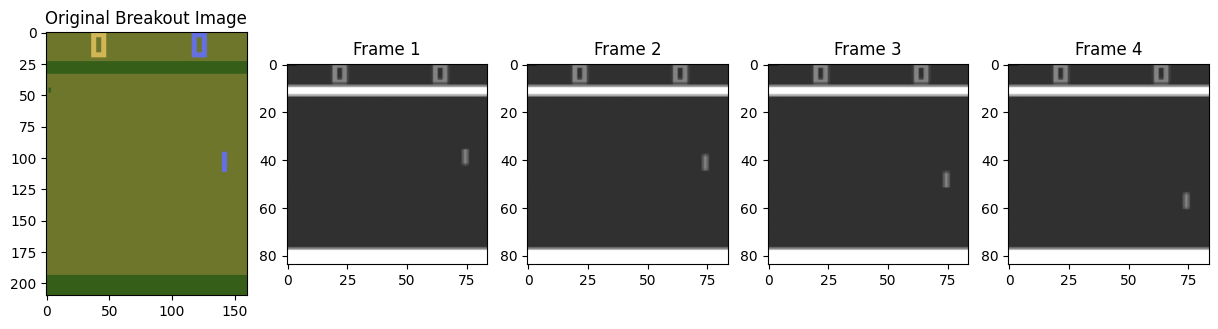

In [9]:
state = np.array(obs)                   # shape (4, 84, 84)
state = np.transpose(state, (1, 2, 0))  # shape (84, 84, 4)

# Run a few steps to get varied frames
for _ in range(3):
    obs, _, _, _, _ = env.step(env.action_space.sample())
    state = np.array(obs)                       # shape (4, 84, 84)
    state = np.transpose(state, (1, 2, 0))      # shape (84, 84, 4)

# Plot the results
plt.figure(figsize=(15, 5))
plt.subplot(1, 5, 1)
plt.imshow(original_rgb)
plt.title('Original Breakout Image')

for i in range(4):
    plt.subplot(1, 5, i + 2)
    plt.imshow(state[:, :, i], cmap='gray')
    plt.title(f'Frame {i + 1}')

plt.show()

### Pre-Requisites

#### Common Constants

In [10]:
LEARNING_FREQ = 4
# Frequency (in steps) at which the model is optimized (e.g., once every 4 steps)

BATCH_SIZE = 32 * LEARNING_FREQ
# Number of transitions sampled from the replay buffer for each training step

REPLAY_MEMORY_BUFFER_SIZE = 30_000
# Maximum number of past transitions stored in the replay buffer

LEARNING_RATE = 1e-4
# Step size used by the optimizer to update network weights

EPSILON_START = 1.0
# Initial value of epsilon — the agent explores completely at the start

EPSILON_END = 0.05
# Final minimum epsilon — even at the end of training, the agent explores 5% of the time

EPSILON_DECAY = 10**5
# Number of steps over which epsilon decays from start to end value (linear decay)

NUM_EPISODES = 400
# Total number of training episodes

LEARNING_START = 1000
# Number of environment steps before training begins (pre-filling the replay buffer)

TARGET_UPDATE_FREQ = 1000
# Frequency (in steps) to update the target network using the policy network's weights

GAMMA = 0.99
# Discount factor for future rewards — how much importance is given to future rewards

TRAINING_METRICS_FILE_NAME = 'train_metrics_DQN.csv'

#### Replay Memory
 * Reference: PyTorch tutorial on [DQN](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html#reinforcement-learning-dqn-tutorial)

In [11]:
# Define a named tuple to store a single transition in the environment
# Each transition contains: (state, action, next_state, reward)
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        """
        Initialize the replay buffer.

        Args:
            capacity (int): Maximum number of transitions to store.
                            Oldest transitions are discarded once capacity is exceeded.
        """
        self.memory = deque([], maxlen=capacity)


    def push(self, *args):
        """
        Save a new transition to the replay buffer.

        Args:
            *args: Values corresponding to (state, action, next_state, reward)
        """
        self.memory.append(Transition(*args))


    def sample(self, batch_size):
        """
        Randomly sample a batch of transitions from the buffer.

        Args:
            batch_size (int): Number of transitions to sample.

        Returns:
            List of sampled Transition tuples.
        """
        return random.sample(self.memory, batch_size)


    def __len__(self):
        """
        Return the current number of transitions stored.

        Returns:
            int: Number of items in the replay buffer.
        """
        return len(self.memory)

#### DQN Network

In [12]:
class DQNNetwork(nn.Module):
    def __init__(self, n_actions):
        """
        Deep Q-Network for Atari-style inputs.

        Args:
            n_actions (int): Number of possible actions the agent can take.
        """
        super().__init__()

        # Convolutional layers for processing stacked image frames (4 in this case)
        self.net = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4),  # -> (32, 20, 20)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),  # -> (64, 9, 9)
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),  # -> (64, 7, 7)
            nn.ReLU(),
        )

         # Fully connected layers to output Q-values for each action
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )


    def forward(self, x):
        """
        Forward pass through the network.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, 4, 84, 84)

        Returns:
            torch.Tensor: Q-values for each action (batch_size, n_actions)
        """
        return self.fc(self.net(x))

#### DQN Agent Class

In [13]:
class DQNAgent:
    def __init__(
            self,
            env: gym.Env,
            replay_buffer: ReplayMemory,
            lr: float,
            batch_size: int,
            device: str,
            is_double_dqn: bool = False
        ):
        """
        Initialize the DQN Agent.

        Args:
            env: The environment.
            replay_buffer: Replay memory for storing transitions.
            lr: Learning rate.
            batch_size: Size of mini-batches sampled from replay buffer.
            device: 'cuda' or 'cpu'.
            is_double_dqn: Whether to use Double DQN for target computation.
        """

        self.env = env
        self.memory = replay_buffer
        self.batch_size = batch_size
        self.is_double_dqn = is_double_dqn

        self.policy_network = DQNNetwork(env.action_space.n).to(device)
        self.target_network = DQNNetwork(env.action_space.n).to(device)
        self.update_target_network()
        self.target_network.eval()

        self.optimizer = optim.AdamW(self.policy_network.parameters(), lr=lr, amsgrad=True)
        self.optimizer.zero_grad()

        self.device = device

    def is_using_prioritized_replay_buffer(self):
        return type(self.memory) != ReplayMemory
    
    def optimise_td_loss(self):
        """
        Optimize the TD error using a mini-batch of sampled transitions.
        Returns the loss value.
        """
        if len(self.memory) < self.batch_size:
            return

        transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))

        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                    if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.policy_network(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1).values
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            if self.is_double_dqn:
                # Double DQN: Use policy_network to select action, target_network to evaluate it
                next_q_values = self.policy_network(non_final_next_states)
                best_actions = next_q_values.argmax(1, keepdim=True)  # Get best action indices
                target_q_values = self.target_network(non_final_next_states).gather(1, best_actions).squeeze(1)
                next_state_values[non_final_mask] = target_q_values
            else:
                # Standard DQN: Use target_network to directly compute max Q-values for next states
                next_state_values[non_final_mask] = self.target_network(non_final_next_states).max(1).values
        
        # Compute the expected Q values
        expected_state_action_values = (next_state_values * GAMMA) + reward_batch

        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()

        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(self.policy_network.parameters(), 100)
        self.optimizer.step()

        return loss.item()

    def update_target_network(self):
        """
        Update the target Q-network by copying the weights from the current Q-network
        """
        self.target_network.load_state_dict(self.policy_network.state_dict())

    def select_action(self, state, epsilon):
        """
        Select an action using epsilon-greedy policy.

        Args:
            state (torch.Tensor): The current state of the environment.
            epsilon (float): The probability of choosing a random action (exploration rate).

        Returns:
            tuple:
                - torch.Tensor: The action to take in the environment.
                - float: The maximum Q-value for the chosen action (None if exploring).
                - float: The average Q-value across all actions (None if exploring).
        """
        sample = random.random()

        if(sample < epsilon):
            return torch.tensor([[self.env.action_space.sample()]], device=device, dtype=torch.long), None, None
        else:
            with torch.no_grad():
                # t.max(1) will return the largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
                action_values  = self.policy_network(state)
                best_action = action_values.max(1).indices.view(1, 1)

                # Get the maximum Q-value of the selected action (expected reward)
                max_q_value = float(action_values.max(1).values)
                
                # Get the average Q-value of all possible actions
                avg_q_value = float(action_values.mean())

                return best_action, max_q_value, avg_q_value

#### Function to calculate epsilon

In [14]:
def get_eps(frame_number):
    """
    Calculate the epsilon value (exploration rate) based on the current frame number.

    The epsilon value decreases linearly from EPSILON_START to EPSILON_END over a 
    range defined by EPSILON_DECAY. If the frame number exceeds EPSILON_DECAY, 
    epsilon is capped at EPSILON_END.

    Args:
        frame_number (int): The current frame number or the number of steps taken by the agent.

    Returns:
        float: The epsilon value (exploration rate) for the given frame number.
    """
    if frame_number > EPSILON_DECAY :
        return EPSILON_END
    
    return EPSILON_START - (EPSILON_START - EPSILON_END)*frame_number/EPSILON_DECAY 

#### DQN Training Function

In [15]:
def train_agent(
        agent: Union[DQNAgent, 'DQNAgentPER'], # type: ignore
        env: gym.Env, 
        episode_rewards: list[float], 
        episode_losses: list[float],
        episode_max_q_values: list[float],
        episode_avg_q_values: list[float],
        steps_per_episode: list[float],
        clipped_episode_rewards: list[int]
    ):
    """
    Train the DQN agent on the specified environment.

    This function runs the training loop where the agent interacts with the environment, 
    learns from the interactions, and updates the policy network. It also stores various 
    statistics related to the training process, such as episode rewards, losses, 
    and Q-values, and prints progress at regular intervals.

    Args:
        agent (DQNAgent): The DQN agent to train.
        env (gym.Env): The environment the agent will interact with.
        episode_rewards (list[float]): List to store the total rewards per episode.
        episode_losses (list[float]): List to store the losses per episode.
        episode_max_q_values (list[float]): List to store the maximum Q-value encountered per episode.
        episode_avg_q_values (list[float]): List to store the average Q-value per episode.
        steps_per_episode (list[float]): List to store the number of steps taken in an episode.
        clipped_episode_rewards (list[int]): List to store the total clipped rewards per episode.

    Returns:
        None: The function modifies the input lists in place to track statistics during training.
    """
    
    # Fill the memory buffer initially with random experiences
    while len(agent.memory) < LEARNING_START:
        state, info = env.reset(seed=SEED)
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        
        for t in count():
            if state is None:
                break       # Skip invalid transitions
            
            # Random action for initial exploration
            action = torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)
            observation, reward, terminated, truncated, _ = env.step(action.item())
            reward = torch.tensor([reward], device=device)
            
            if terminated:
                next_state = None
            else:
                next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

            agent.memory.push(state, action, next_state, reward)

            state = next_state
            
            if env.spec.id.startswith("Breakout") and (info['lives'] == 0 or len(agent.memory) >= LEARNING_START):
                break
            elif len(agent.memory) >= LEARNING_START:
                break
    
    print(f"[INFO] Replay memory pre-filled with {len(agent.memory)} transitions. Beginning training...\n")
    
    # Initialize tracking variables
    steps_done = 0
    steps_at_last_update = 0

    # Begin the training loop
    for i_episode in range(NUM_EPISODES):
        # Initialize the environment and get its state
        state, _ = env.reset(seed=SEED)
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        done = False
        total_reward = 0
        total_clipped_reward = 0
        total_losses = 0
        max_q = -float('Inf')
        episode_avg_q = 0
        actions_chosen = 0
        reward_counter = Counter()
        steps_this_episode = 0

        # Run through each time step of the episode
        while not done:
            action, q_val, avg_q_val = agent.select_action(state, get_eps(steps_done))
            
            # Track max Q-value for the episode
            if (q_val is not None) and max_q < q_val:
                max_q = q_val
            
            # Track average Q-value for the episode
            if (avg_q_val is not None):
                actions_chosen += 1
                episode_avg_q += (avg_q_val - episode_avg_q) / actions_chosen

            # Take the chosen action in the environment
            observation, reward, terminated, truncated, _ = env.step(action.item())

            total_reward += reward
            reward_counter[int(reward)] += 1
            total_clipped_reward = int(np.sign(reward))
            
            reward = torch.tensor([reward], device=device)
            done = terminated or truncated

            if terminated:
                next_state = None
            else:
                next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

            # Store the transition in memory
            agent.memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state

            # Increment steps and optimize model periodically
            steps_done += 1
            if steps_done % LEARNING_FREQ == 0:
                if agent.is_using_prioritized_replay_buffer():
                    loss = agent.optimise_td_loss(get_eps(steps_done))
                else:
                    loss = agent.optimise_td_loss()
                if loss:
                    total_losses += loss

            # Update the target network periodically
            if (steps_done - steps_at_last_update) > TARGET_UPDATE_FREQ:
                agent.update_target_network()
                steps_at_last_update = steps_done

            # Steps completed in this episode
            steps_this_episode += 1
            
            # End of the episode
            if done:
                # Append results to the respective lists
                episode_rewards.append(total_reward)
                episode_losses.append(total_losses)
                episode_max_q_values.append(max_q)
                episode_avg_q_values.append(episode_avg_q)
                steps_per_episode.append(steps_this_episode)
                clipped_episode_rewards.append(total_clipped_reward)

                # Print progress every 500 episodes
                if (i_episode+1) % 25 == 0:
                    mean_10_reward = round(np.mean(episode_rewards[-10:]), 1)
                    print(
                        f"Episode {(i_episode+1)}/{NUM_EPISODES} | "
                        f"Epsilon: {get_eps(steps_done):.3f} | "
                        f"Rewards this episode: {dict(reward_counter)} | "
                        f"Avg Reward (last 10): {mean_10_reward:.2f}"
                    )

#### Function to log metrics

In [16]:
def log_training_metrics_to_csv(
    filename: str,
    episode_rewards: list,
    episode_losses: list,
    episode_max_q_vals: list,
    episode_avg_q_vals: list,
    steps_per_episode: list,
    clipped_episode_rewards: list,
    dqn_type: str = 'vanilla'
):
    """
    Logs training metrics to a CSV file. Creates the file with headers if it doesn't exist, otherwise appends to it.

    Args:
        filename (str): Name/path of the CSV file.
        episode_rewards (list): List of rewards per episode.
        episode_losses (list): List of total loss values per episode.
        episode_max_q_vals (list): List of maximum Q-values per episode.
        episode_avg_q_vals (list): List of average Q-values per episode.
        steps_per_episode (list): List of steps taken per episode.
        clipped_episode_rewards (list): List of clipped rewards per episode.
        dqn_type (str). Prefix for column names to indicate DQN type. Defaults to 'vanilla'.
    """
    dqn_type = dqn_type.lower()
    data = {
        f'{dqn_type}_reward': episode_rewards,
        f'{dqn_type}_loss': episode_losses,
        f'{dqn_type}_max_q_value': episode_max_q_vals,
        f'{dqn_type}_avg_q_value': episode_avg_q_vals,
        f'{dqn_type}_steps': steps_per_episode,
        f'{dqn_type}_clipped_reward': clipped_episode_rewards
    }

    if os.path.isfile(filename):
        # Read existing CSV file
        df = pd.read_csv(filename).reset_index(drop=True)

        new_df = pd.DataFrame(data).reset_index(drop=True)

        # Extend df if new_df has more rows
        if len(new_df) > len(df):
            missing_rows = new_df[len(df):]
            df = pd.concat([df, pd.DataFrame(index=missing_rows.index)], ignore_index=False)

        # Update or add columns
        for col in new_df.columns:
            df[col] = new_df[col]
    else:
        # If the file doesn't exist, create a new DataFrame
        df = pd.DataFrame(data)

    # Save the DataFrame back to the CSV file
    df.to_csv(filename, index=False)

    print(f"Training metrics successfully logged to '{filename}'")


### 3. VANILLA DQN Implementation

#### a. Capture and Pre-processing of the Data

The pre-processing of data in Vanilla DQN is an essential step to ensure the input to the neural network is clean and computationally manageable. This process involves several steps, including converting frames to a consistent format, reducing their dimensionality, and stacking multiple frames to create a temporal context for the agent's decisions.

In the case of Atari environments from OpenAI Gym, the following pre-processing pipeline is used [Implemented in Environment Section](#2-environment):

* AtariPreprocessing: The environment is wrapped with AtariPreprocessing to apply several common transformations:
    - Noop Reset: Obtains the initial state by taking a random number of no-ops on reset, default max 30 no-ops.
    - Frame skipping: The number of frames skipped between steps, 4 by default.
    - Max-pooling: Pools over the most recent two observations from the frame skips.
    - Termination signal when a life is lost: When the agent losses a life during the environment, then the environment is terminated.
            Turned off by default. Not recommended by Machado et al. (2018).
    - Resize to a square image: Resizes the atari environment original observation shape from 210x180 to 84x84 by default.
    - Grayscale observation: Makes the observation greyscale, enabled by default.
    - Grayscale new axis: Extends the last channel of the observation such that the image is 3-dimensional, not enabled by default.
    - Scale observation: Whether to scale the observation between [0, 1) or [0, 255), not scaled by default.

* From the above mentioned transformations, I have changed

    - Frame Skip: The _**`ALE/Breakout-v5`**_ already has a frame_skip=4. Setting frame_skip=1 in this wrapper, otherwise more than one frame-skip will happen as through this wrapper.

    - Scaling: The frames are scaled to have values between 0 and 1 (scale_obs=True), which helps with model convergence and avoids large gradients during training.

* Stacking Frames: The environment is wrapped again with FrameStackObservation, where 4 consecutive frames are stacked. This allows the agent to see a sequence of frames, providing it with temporal context to make decisions. Stacking is essential in environments like Breakout, where the agent needs to understand the movement of objects over time (e.g., the ball's velocity and trajectory in the game).

#### b. The Network Structure

I have used the same convolutional architecture as the original DQN paper:

[Navigate to the Network code](#DQN-network)

1. Convolutional Layers:

    - 32 filters, 8x8 kernel, stride 4.

    - 64 filters, 4x4 kernel, stride 2.

    - 64 filters, 3x3 kernel, stride 1.

2. Fully Connected Layers:

    After the convolutions, the output is flattened and passed through:

    - A fully connected layer with 512 units and ReLU activation.

    - A final layer outputting Q-values for each action (n_actions).

3. Forward Pass:

    The network processes the input image through convolutional layers to extract features, then uses fully connected layers to output Q-values for each action.

In [16]:
temp_net = DQNNetwork(env.action_space.n).to(device)
summary(temp_net, input_size=obs.shape)
del temp_net
torch.cuda.empty_cache()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 20, 20]           8,224
              ReLU-2           [-1, 32, 20, 20]               0
            Conv2d-3             [-1, 64, 9, 9]          32,832
              ReLU-4             [-1, 64, 9, 9]               0
            Conv2d-5             [-1, 64, 7, 7]          36,928
              ReLU-6             [-1, 64, 7, 7]               0
           Flatten-7                 [-1, 3136]               0
            Linear-8                  [-1, 512]       1,606,144
              ReLU-9                  [-1, 512]               0
           Linear-10                    [-1, 6]           3,078
Total params: 1,687,206
Trainable params: 1,687,206
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 0.35
Params size (MB): 6.44
Estimat

#### c. Q-Learning Update applied to the weights

 <h5>Experience Replay</h5>

The learning algorithm uses a replay buffer, which is a pool of past experiences stored as tuples: $(s,a,s',r)$ where:
- _**`s`**_: current state
- _**`a`**_: action taken  
- _**`s'`**_: next state
- _**`r`**_: reward received  

<span style="color:red">Note: The original [paper](https://www.nature.com/articles/nature14236) implements the experience tuple as: $(s,a,r, s')$. I have used the order above in the code and explanations.</span>

During training, the agent samples a minibatch of experiences uniformly at random from this buffer.

<h5>Q-learning Update (Loss Function)</h5>

For each experience in the minibatch, the agent minimizes the following loss function at training iteration _i_:

$$
\mathcal{L}_{i}(\theta)_{i} \;=\;
\mathbb{E}_{(s,a,s',r) \sim \mathcal U(D)}\Bigl[\bigl(r + \gamma\max_{a'}Q(s',a';\theta^-_{i})\;-\;Q(s,a;\theta_{i})\bigr)^{2}\Bigr].
$$

- $Q(s,a;\theta_{i})$: The predicted Q-value for state _s_, action _a_, using the `current Q-network` with parameters $\theta_{i}$
- $Q(s',a';\theta^-_{i})$: The target Q-value for the next state _s'_, calculated using a `target network` with parameters $\theta^-_{i}$
- $\gamma$: Discount factor (between 0 and 1), which determines the importance of future rewards.
- $r$: The reward received after taking action _a_ in state _s_, represents the immediate feedback from the environment.
- The expression inside the square is the `temporal difference (TD) error`, which the network aims to minimize.

Target Network $\theta^-_{i}$

The target network is a delayed copy of the Q-network.

- It is held fixed for _C_ steps.
- Its parameters $\theta^-_{i}$ are updated to match $\theta_{i}$ only every _C_ iterations.
- This stabilizes learning by preventing the target values from shifting too rapidly during updates.



#### Start Training

In [17]:
replay_memory = ReplayMemory(REPLAY_MEMORY_BUFFER_SIZE)
dqn_agent = DQNAgent(
        env=env,
        replay_buffer=replay_memory,
        lr=LEARNING_RATE,
        batch_size=BATCH_SIZE,
        device=device
    )

vanilla_dqn_episode_rewards = []
vanilla_dqn_episode_losses = []
vanilla_dqn_episode_max_q = []
vanilla_dqn_episode_avg_q = []
vanilla_dqn_steps_per_episode = []
vanilla_dqn_clipped_episode_rewards = []

train_agent(
    dqn_agent,
    env,
    vanilla_dqn_episode_rewards,
    vanilla_dqn_episode_losses,
    vanilla_dqn_episode_max_q,
    vanilla_dqn_episode_avg_q,
    vanilla_dqn_steps_per_episode,
    vanilla_dqn_clipped_episode_rewards
    )

print("-" * 50)

log_training_metrics_to_csv(
    TRAINING_METRICS_FILE_NAME,
    vanilla_dqn_episode_rewards,
    vanilla_dqn_episode_losses,
    vanilla_dqn_episode_max_q,
    vanilla_dqn_episode_avg_q,
    vanilla_dqn_steps_per_episode,
    vanilla_dqn_clipped_episode_rewards,
    dqn_type='vanilla'
)

[INFO] Replay memory pre-filled with 1000 transitions. Beginning training...

Episode 25/400 | Epsilon: 0.785 | Rewards this episode: {0: 848, -1: 21} | Avg Reward (last 10): -20.00
Episode 50/400 | Epsilon: 0.564 | Rewards this episode: {0: 856, -1: 21} | Avg Reward (last 10): -19.70
Episode 75/400 | Epsilon: 0.330 | Rewards this episode: {0: 1262, -1: 21, 1: 4} | Avg Reward (last 10): -20.00
Episode 100/400 | Epsilon: 0.050 | Rewards this episode: {0: 1846, -1: 21, 1: 1} | Avg Reward (last 10): -19.10
Episode 125/400 | Epsilon: 0.050 | Rewards this episode: {0: 1711, -1: 21, 1: 1} | Avg Reward (last 10): -17.40
Episode 150/400 | Epsilon: 0.050 | Rewards this episode: {0: 2993, -1: 21, 1: 7} | Avg Reward (last 10): -15.50
Episode 175/400 | Epsilon: 0.050 | Rewards this episode: {0: 2703, -1: 21, 1: 8} | Avg Reward (last 10): -13.20
Episode 200/400 | Epsilon: 0.050 | Rewards this episode: {0: 1909, -1: 21, 1: 1} | Avg Reward (last 10): -10.30
Episode 225/400 | Epsilon: 0.050 | Rewards 

### 4. Results and Evaluation for VANILLA DQN

##### a. Plots with short explanations

* Total Reward per Episode – DQN: This plot shows how much reward the agent gets in each episode (green line). The purple line is the moving average, which smooths the rewards over the last 100 episodes to show the overall trend. If the moving average is going up, it means the agent is learning and getting better at the game. If it stays flat or drops, the agent might not be improving.

* Total Loss per Episode – DQN: This plot shows the loss during training (red line), which tells us how far the agent's predictions are from the correct values. The blue line is the moving average of the loss. A lower and stable loss means the agent is learning well. If the loss stays high or jumps around a lot, it may mean there’s a problem with the training.

##### b. How does one evaluate the performance of the RL agent?

The performance of the RL agent may be evaluated by several methods:

* Total reward per episode
* Moving average of rewards across a window of episodes
* Decreasing loss
* Comparison to benchmarks

##### c. Is the agent learning?

Yes, the agent is learning as the rewards are increasing over time.

In [30]:
def plot_performance_metrics(csv_file_path: str, dqn_type: str = 'vanilla', window_size: int = 50):
    """
    Plots training performance metrics from a CSV file in a 2x2 subplot layout.

    Args:
        csv_file_path (str): Path to the CSV file containing logged training data.
        dqn_type (str): Prefix used in column names to distinguish DQN variant. Default is 'vanilla'.
        window_size (int): Window size for computing moving average. Default is 50.
    """
    df = pd.read_csv(csv_file_path)

    dqn_type = dqn_type.lower()

    # Construct full column names
    reward_col = f'{dqn_type}_reward'
    loss_col = f'{dqn_type}_loss'
    max_q_col = f'{dqn_type}_max_q_value'
    avg_q_col = f'{dqn_type}_avg_q_value'
    clipped_reward_col = f'{dqn_type}_clipped_reward'
    steps_col = f'{dqn_type}_steps'

    rewards = df[reward_col]
    losses = df[loss_col]
    max_q_vals = df[max_q_col]
    avg_q_vals = df[avg_q_col]
    clipped_rewards = df[clipped_reward_col]
    steps = df[steps_col]
    episodes = list(range(1, df.shape[0]+1))

    # Setup 2x2 plot grid
    fig, axs = plt.subplots(3, 2, figsize=(14, 12))
    if dqn_type == 'd3qn_per':
        fig.suptitle('Dueling Double DQN with Prioritized Experience Replay - Training Metrics', fontsize=16)
    else:
        fig.suptitle(f'{dqn_type.upper()} DQN - Training Metrics', fontsize=16)

    # Row 1: Reward, Loss and thrie moving averages
    reward_avg = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
    axs[0, 0].plot(episodes, rewards, label='Reward', color='seagreen', alpha=0.5)
    axs[0, 0].plot(episodes[window_size - 1:], reward_avg, label=f'Moving Avg (Window - {window_size})', color='lime')
    axs[0, 0].set_title('Total Reward per Episode')
    axs[0, 0].set_xlabel('Episode')
    axs[0, 0].set_ylabel('Reward')
    axs[0, 0].grid(True)
    axs[0, 0].legend()

    loss_avg = np.convolve(losses, np.ones(window_size)/window_size, mode='valid')
    axs[0, 1].plot(episodes, losses, label='Loss', color='indianred', alpha=0.5)
    axs[0, 1].plot(episodes[window_size - 1:], loss_avg, label=f'Moving Avg (Window - {window_size})', color='red')
    axs[0, 1].set_title(f'Moving Average Reward')
    axs[0, 1].set_xlabel('Episode')
    axs[0, 1].set_ylabel('Avg Reward')
    axs[0, 1].grid(True)
    axs[0, 1].legend()

    # Row 2: Clipped Reward and Steps per episode
    axs[1, 0].plot(episodes, clipped_rewards, label='Clipped Reward', color='mediumorchid')
    axs[1, 0].set_title('Clipped Reward per Episode')
    axs[1, 0].set_xlabel('Episode')
    axs[1, 0].set_ylabel('Clipped Reward')
    axs[1, 0].grid(True)
    axs[1, 0].legend()

    axs[1, 1].plot(episodes, steps, label='Steps', color='aqua')
    axs[1, 1].set_title(f'Steps per Episode')
    axs[1, 1].set_xlabel('Episode')
    axs[1, 1].set_ylabel('Steps')
    axs[1, 1].grid(True)
    axs[1, 1].legend()

    # Row 3: Max Q and Avg Q (raw values)
    axs[2, 0].plot(episodes, max_q_vals, label='Max Q-Value', color='goldenrod')
    axs[2, 0].set_title('Max Q-Value per Episode')
    axs[2, 0].set_xlabel('Episode')
    axs[2, 0].set_ylabel('Q-Value')
    axs[2, 0].grid(True)
    axs[2, 0].legend()

    axs[2, 1].plot(episodes, avg_q_vals, label='Avg Q-Value', color='dodgerblue')
    axs[2, 1].set_title('Avg Q-Value per Episode')
    axs[2, 1].set_xlabel('Episode')
    axs[2, 1].set_ylabel('Q-Value')
    axs[2, 1].grid(True)
    axs[2, 1].legend()

    # Final adjustments
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

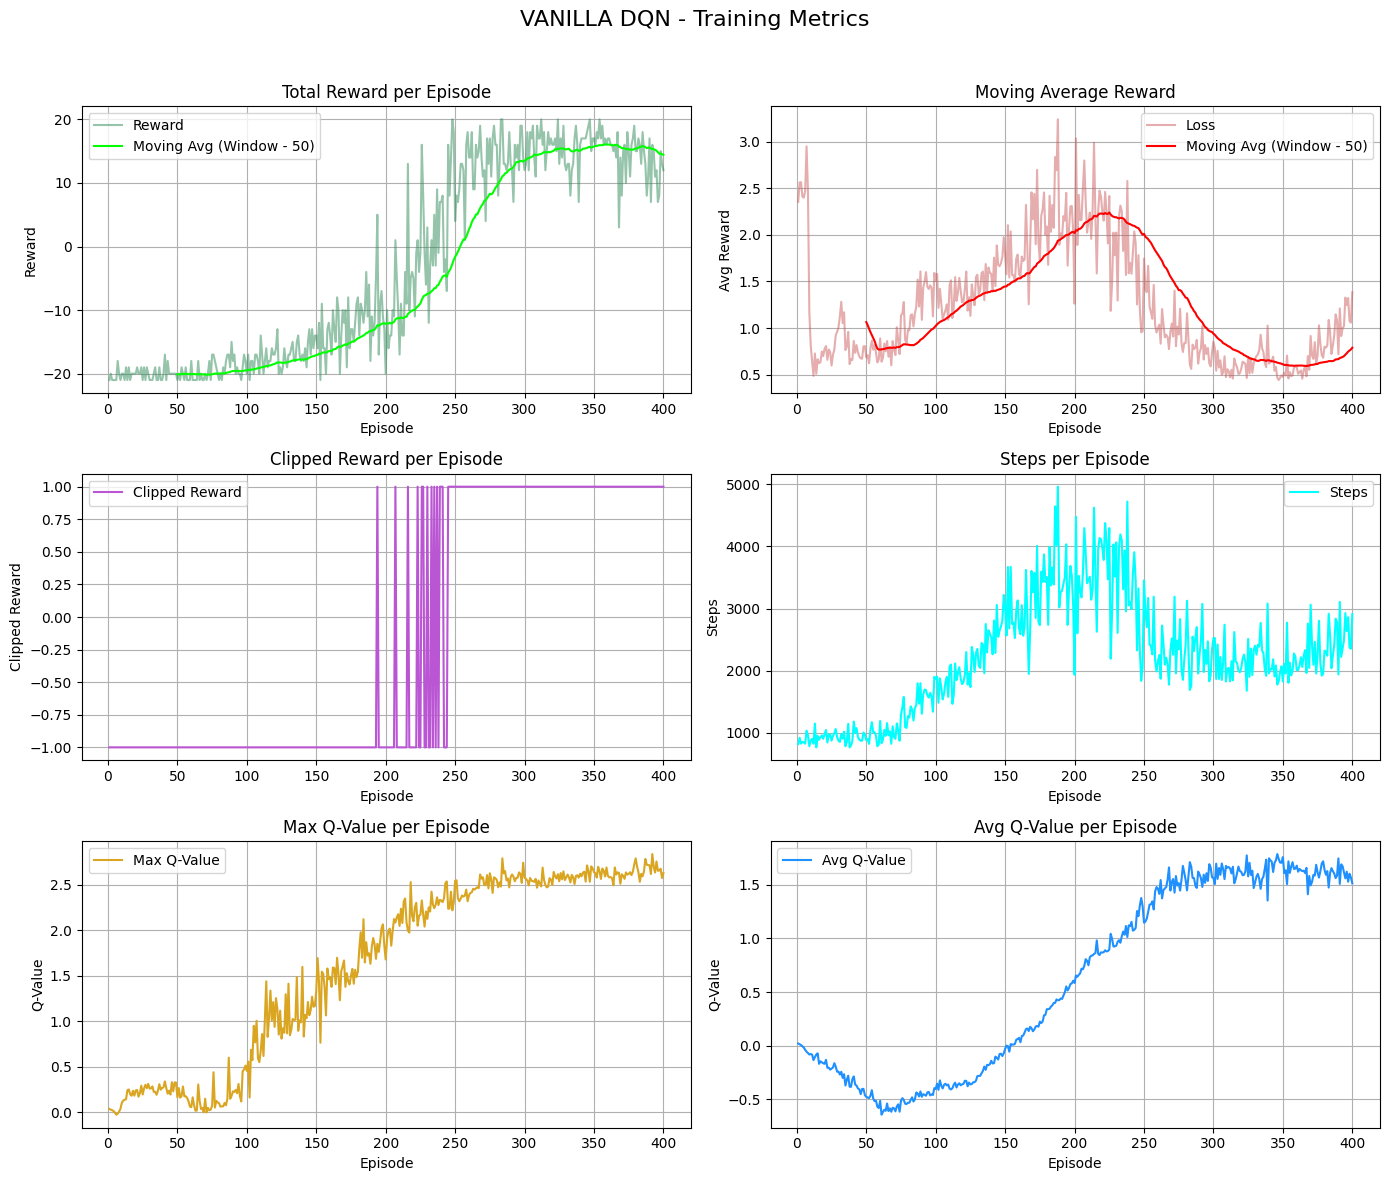

In [17]:
plot_performance_metrics(csv_file_path=TRAINING_METRICS_FILE_NAME, dqn_type='vanilla')

### 4. DOUBLE DQN (DDQN) Implementation

#### a. Describe the problem being addressed

In the vanilla DQN algorithm, the agent can overestimate Q-values due to the use of the same network for both selecting and evaluating actions during the Q-value update. This overestimation arises when taking the maximum Q-value over estimated actions, a bias that can lead to unstable learning, suboptimal policies, and poor sample efficiency, especially in complex environments like Atari games.

This overestimation can cause the agent to prefer actions that look rewarding according to noisy Q estimates, rather than actions that are truly optimal. This may result in the agent failing to learn a reliable strategy.

#### b. Describe the theoretical solution

DDQN addresses the overestimation bias in vanilla DQN by decoupling the action selection and action evaluation steps during the target Q-value computation. Instead of using the same network to both choose the best next action and evaluate its value, DDQN uses:
- The policy network to select the best next action.
- The target network to evaluate the Q-value of that action.

This change results in a more accurate and unbiased target, which stabilizes training and improves learning performance.

The target for DDQN becomes (Source: [DDQN Paper](https://arxiv.org/pdf/1509.06461)):

$$
\mathcal{Y}^{DoubleDQN}_{t} \;≡\;
\mathcal{R}_{t+1} + {\gamma}Q(s_{t+1}, \argmax_{a}Q(s_{t+1}, a; \theta_{t}), \theta^-_{t}).
$$

- ${y}^{DoubleDQN}_{t}$​: The target Q-value at time step _t_

- $R_{t+1}$​: The reward received after taking action $a_{t}​$

- $\gamma$: The discount factor

- $arg⁡maxQ(s_{t+1}, a; \theta_{t})$: Selects the best action, from Q-values predicted by the policy network

- $Q({s_{t+1}, ., \theta^-_{t}})$: The target network evaluates the selected action

- $\theta_{t}$​: Parameters of the online network

- $\theta^-_{t}$​: Parameters of the target network

This modification improves the agent's ability to estimate long-term returns more reliably, leading to better gameplay strategies.

In [16]:
replay_memory = ReplayMemory(REPLAY_MEMORY_BUFFER_SIZE)
double_dqn_agent = DQNAgent(
        env=env,
        replay_buffer=replay_memory,
        lr=LEARNING_RATE,
        batch_size=BATCH_SIZE,
        device=device,
        is_double_dqn=True
    )

double_dqn_episode_rewards = []
double_dqn_episode_losses = []
double_dqn_episode_max_q = []
double_dqn_episode_avg_q = []
double_dqn_steps_per_episode = []
double_dqn_clipped_episode_rewards = []

train_agent(
    double_dqn_agent,
    env,
    double_dqn_episode_rewards,
    double_dqn_episode_losses,
    double_dqn_episode_max_q,
    double_dqn_episode_avg_q,
    double_dqn_steps_per_episode,
    double_dqn_clipped_episode_rewards
    )

print("-" * 50)

log_training_metrics_to_csv(
    TRAINING_METRICS_FILE_NAME,
    double_dqn_episode_rewards,
    double_dqn_episode_losses,
    double_dqn_episode_max_q,
    double_dqn_episode_avg_q,
    double_dqn_steps_per_episode,
    double_dqn_clipped_episode_rewards,
    dqn_type='double',
)

[INFO] Replay memory pre-filled with 1000 transitions. Beginning training...

Episode 25/400 | Epsilon: 0.789 | Rewards this episode: {0: 952, -1: 21, 1: 1} | Avg Reward (last 10): -19.90
Episode 50/400 | Epsilon: 0.570 | Rewards this episode: {0: 877, -1: 21, 1: 1} | Avg Reward (last 10): -19.80
Episode 75/400 | Epsilon: 0.347 | Rewards this episode: {0: 942, -1: 21} | Avg Reward (last 10): -20.50
Episode 100/400 | Epsilon: 0.068 | Rewards this episode: {0: 860, -1: 21} | Avg Reward (last 10): -19.80
Episode 125/400 | Epsilon: 0.050 | Rewards this episode: {0: 1893, -1: 21} | Avg Reward (last 10): -19.30
Episode 150/400 | Epsilon: 0.050 | Rewards this episode: {0: 1825, -1: 21, 1: 2} | Avg Reward (last 10): -18.10
Episode 175/400 | Epsilon: 0.050 | Rewards this episode: {0: 3407, 1: 12, -1: 21} | Avg Reward (last 10): -11.40
Episode 200/400 | Epsilon: 0.050 | Rewards this episode: {0: 2599, -1: 21, 1: 13} | Avg Reward (last 10): -8.70
Episode 225/400 | Epsilon: 0.050 | Rewards this ep

### 6. Results and Evaluation for DOUBLE DQN

##### Plots with short explanations

* Total Reward per Episode – DDQN: This plot shows how much reward the agent gets in each episode (green line). The purple line is the moving average, which smooths the rewards over the last 100 episodes to show the overall trend. If the moving average is going up, it means the agent is learning and getting better at the game. If it stays flat or drops, the agent might not be improving.

* Total Loss per Episode – DDQN: This plot shows the loss during training (red line), which tells us how far the agent's predictions are from the correct values. The blue line is the moving average of the loss. A lower and stable loss means the agent is learning well. If the loss stays high or jumps around a lot, it may mean there’s a problem with the training.

##### Is the agent learning?

Yes, the agent is learning as the rewards are increasing over time.

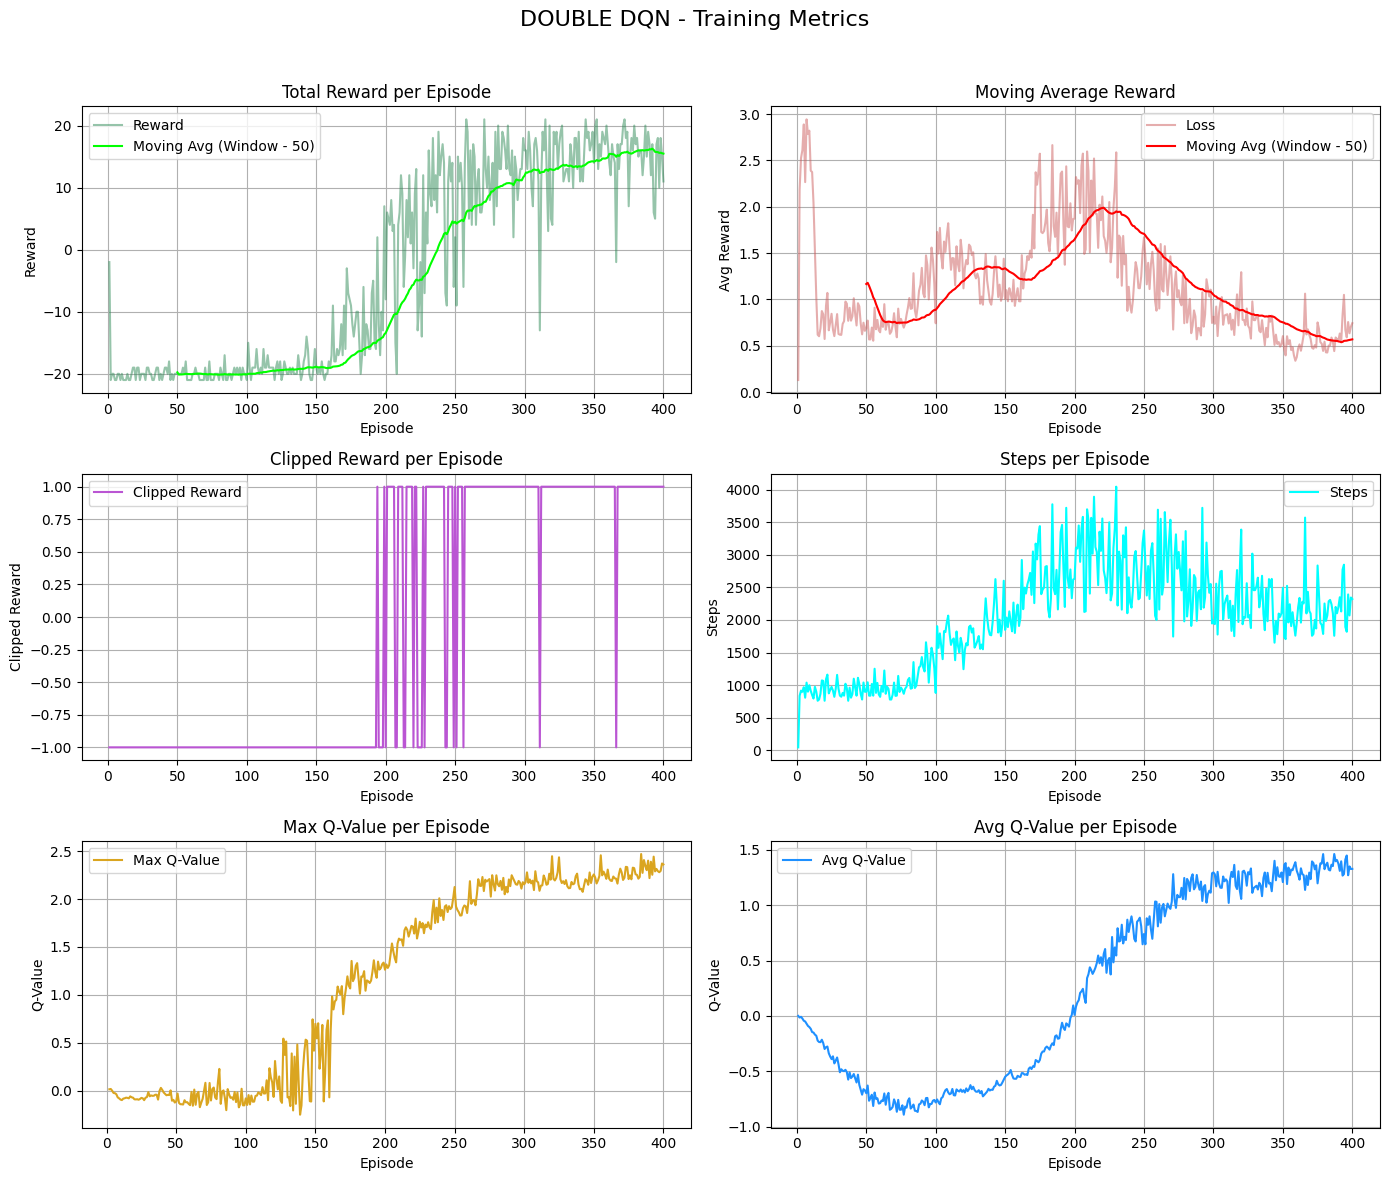

In [20]:
plot_performance_metrics(csv_file_path=TRAINING_METRICS_FILE_NAME, dqn_type='double')

### 7. Comparison of DQN versus DOUBLE DQN

##### Plots with short explanations

* Total Reward per Episode – DDQN: This plot shows how much reward the agent gets in each episode (green line). The purple line is the moving average, which smooths the rewards over the last 100 episodes to show the overall trend. If the moving average is going up, it means the agent is learning and getting better at the game. If it stays flat or drops, the agent might not be improving.

* Total Loss per Episode – DDQN: This plot shows the loss during training (red line), which tells us how far the agent's predictions are from the correct values. The blue line is the moving average of the loss. A lower and stable loss means the agent is learning well. If the loss stays high or jumps around a lot, it may mean there’s a problem with the training.

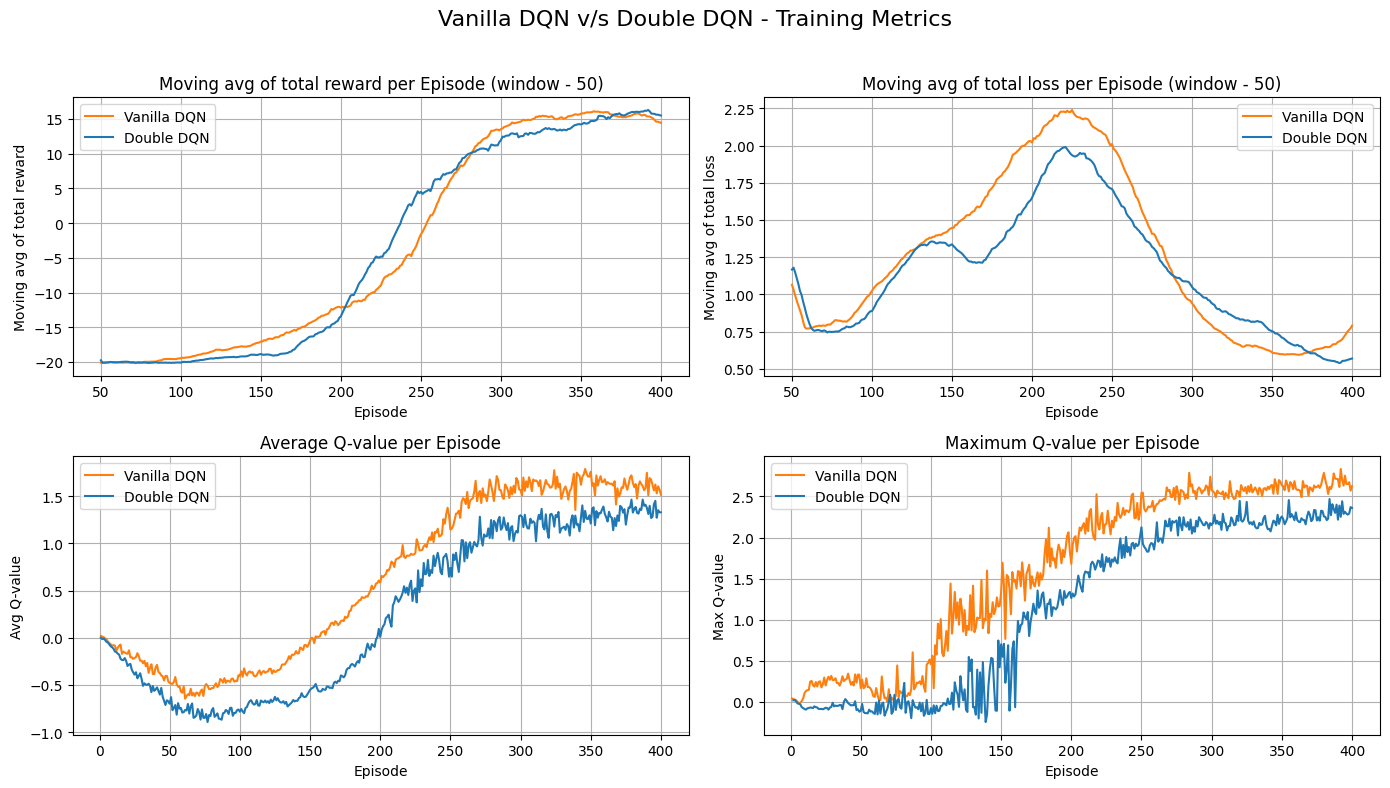

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('train_metrics_DQN.csv')

window_size = 50

# vanilla dqn metrics

vdqn_rewards = df['vanilla_reward']
vdqn_loss = df['vanilla_loss']
vdqn_max_q = df['vanilla_max_q_value']
vdqn_avg_q = df['vanilla_avg_q_value']
vdqn_rewards = df['vanilla_reward']
vdqn_mov_avg_rewards = np.convolve(vdqn_rewards, np.ones(window_size)/window_size, mode='valid')
vdqn_mov_avg_loss = np.convolve(vdqn_loss, np.ones(window_size)/window_size, mode='valid')

# double dqn metrics

ddqn_rewards = df['double_reward']
ddqn_loss = df['double_loss']
ddqn_max_q = df['double_max_q_value']
ddqn_avg_q = df['double_avg_q_value']
ddqn_rewards = df['double_reward']
ddqn_mov_avg_rewards = np.convolve(ddqn_rewards, np.ones(window_size)/window_size, mode='valid')
ddqn_mov_avg_loss = np.convolve(ddqn_loss, np.ones(window_size)/window_size, mode='valid')

episodes = list(range(1, df.shape[0]+1))

fig, axs = plt.subplots(2, 2, figsize=(14, 8))
fig.suptitle('Vanilla DQN v/s Double DQN - Training Metrics', fontsize=16)

axs[0, 0].plot(episodes[window_size - 1:], vdqn_mov_avg_rewards, label='Vanilla DQN', color='tab:orange')
axs[0, 0].plot(episodes[window_size - 1:], ddqn_mov_avg_rewards, label='Double DQN', color='tab:blue')
axs[0, 0].set_title(f'Moving avg of total reward per Episode (window - {window_size})')
axs[0, 0].set_xlabel('Episode')
axs[0, 0].set_ylabel('Moving avg of total reward')
axs[0, 0].grid(True)
axs[0, 0].legend()

axs[0, 1].plot(episodes[window_size - 1:], vdqn_mov_avg_loss, label='Vanilla DQN', color='tab:orange')
axs[0, 1].plot(episodes[window_size - 1:], ddqn_mov_avg_loss, label='Double DQN', color='tab:blue')
axs[0, 1].set_title(f'Moving avg of total loss per Episode (window - {window_size})')
axs[0, 1].set_xlabel('Episode')
axs[0, 1].set_ylabel('Moving avg of total loss')
axs[0, 1].grid(True)
axs[0, 1].legend()

axs[1, 0].plot(episodes, vdqn_avg_q, label='Vanilla DQN', color='tab:orange')
axs[1, 0].plot(episodes, ddqn_avg_q, label='Double DQN', color='tab:blue')
axs[1, 0].set_title(f'Average Q-value per Episode')
axs[1, 0].set_xlabel('Episode')
axs[1, 0].set_ylabel('Avg Q-value')
axs[1, 0].grid(True)
axs[1, 0].legend()

axs[1, 1].plot(episodes, vdqn_max_q, label='Vanilla DQN', color='tab:orange')
axs[1, 1].plot(episodes, ddqn_max_q, label='Double DQN', color='tab:blue')
axs[1, 1].set_title(f'Maximum Q-value per Episode')
axs[1, 1].set_xlabel('Episode')
axs[1, 1].set_ylabel('Max Q-value')
axs[1, 1].grid(True)
axs[1, 1].legend()

# Final adjustments
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### 8. Added Value

In [18]:
ADDED_VALUE_TRAINING_METRICS_FILE_NAME = 'added_value_train_metrics_DQN.csv'

##### a. Dueling Double DQN (D3QN)

In [19]:
class DuelingDQN(nn.Module):
    def __init__(self, n_actions):
        super().__init__()

        # Shared convolutional base
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4),  # -> (32, 20, 20)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),  # -> (64, 9, 9)
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),  # -> (64, 7, 7)
            nn.ReLU(),
            nn.Flatten()
        )

        # Size of flattened feature map: 64 * 7 * 7 = 3136
        feature_size = 64 * 7 * 7

        # Value stream
        self.value_stream = nn.Sequential(
            nn.Linear(feature_size, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )

        # Advantage stream
        self.advantage_stream = nn.Sequential(
            nn.Linear(feature_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def forward(self, x):
        features = self.feature_extractor(x)

        value = self.value_stream(features)                  # (batch_size, 1)
        advantage = self.advantage_stream(features)          # (batch_size, n_actions)

        # Combine streams using the dueling formula
        q_vals = value + advantage - advantage.mean(dim=1, keepdim=True)
        return q_vals

In [20]:
class DuelingDQNAgent(DQNAgent):
    def __init__(
            self,
            env: gym.Env,
            replay_buffer: ReplayMemory,
            lr: float,
            batch_size: int,
            device: str,
            is_double_dqn: bool = False
        ):

        self.env = env
        self.memory = replay_buffer
        self.batch_size = batch_size
        self.is_double_dqn = is_double_dqn

        self.policy_network = DuelingDQN(env.action_space.n).to(device)
        self.target_network = DuelingDQN(env.action_space.n).to(device)
        self.update_target_network()
        self.target_network.eval()

        self.optimizer = optim.AdamW(self.policy_network.parameters(), lr=lr, amsgrad=True)
        self.optimizer.zero_grad()

        self.device = device

In [22]:
replay_memory = ReplayMemory(REPLAY_MEMORY_BUFFER_SIZE)
dueling_double_dqn_agent = DuelingDQNAgent(
        env=env,
        replay_buffer=replay_memory,
        lr=LEARNING_RATE,
        batch_size=BATCH_SIZE,
        device=device,
        is_double_dqn=True
    )

dueling_double_dqn_episode_rewards = []
dueling_double_dqn_episode_losses = []
dueling_double_dqn_episode_max_q = []
dueling_double_dqn_episode_avg_q = []
dueling_double_dqn_steps_per_episode = []
dueling_double_dqn_clipped_episode_rewards = []

train_agent(
    dueling_double_dqn_agent,
    env, 
    dueling_double_dqn_episode_rewards,
    dueling_double_dqn_episode_losses,
    dueling_double_dqn_episode_max_q,
    dueling_double_dqn_episode_avg_q,
    dueling_double_dqn_steps_per_episode,
    dueling_double_dqn_clipped_episode_rewards
    )

log_training_metrics_to_csv(
    ADDED_VALUE_TRAINING_METRICS_FILE_NAME,
    dueling_double_dqn_episode_rewards,
    dueling_double_dqn_episode_losses,
    dueling_double_dqn_episode_max_q,
    dueling_double_dqn_episode_avg_q,
    dueling_double_dqn_steps_per_episode,
    dueling_double_dqn_clipped_episode_rewards,
    dqn_type='dueling_double'
    )

[INFO] Replay memory pre-filled with 1000 transitions. Beginning training...

Episode 25/400 | Epsilon: 0.774 | Rewards this episode: {0: 990, -1: 21, 1: 2} | Avg Reward (last 10): -19.60
Episode 50/400 | Epsilon: 0.549 | Rewards this episode: {0: 1089, -1: 21, 1: 1} | Avg Reward (last 10): -20.30
Episode 75/400 | Epsilon: 0.229 | Rewards this episode: {0: 1479, -1: 21, 1: 3} | Avg Reward (last 10): -17.60
Episode 100/400 | Epsilon: 0.050 | Rewards this episode: {0: 2632, -1: 21, 1: 12} | Avg Reward (last 10): -10.90
Episode 125/400 | Epsilon: 0.050 | Rewards this episode: {0: 2824, 1: 14, -1: 21} | Avg Reward (last 10): -4.40
Episode 150/400 | Epsilon: 0.050 | Rewards this episode: {0: 2827, -1: 13, 1: 21} | Avg Reward (last 10): 14.40
Episode 175/400 | Epsilon: 0.050 | Rewards this episode: {0: 2135, -1: 5, 1: 21} | Avg Reward (last 10): 14.70
Episode 200/400 | Epsilon: 0.050 | Rewards this episode: {0: 1930, -1: 5, 1: 21} | Avg Reward (last 10): 15.90
Episode 225/400 | Epsilon: 0.05

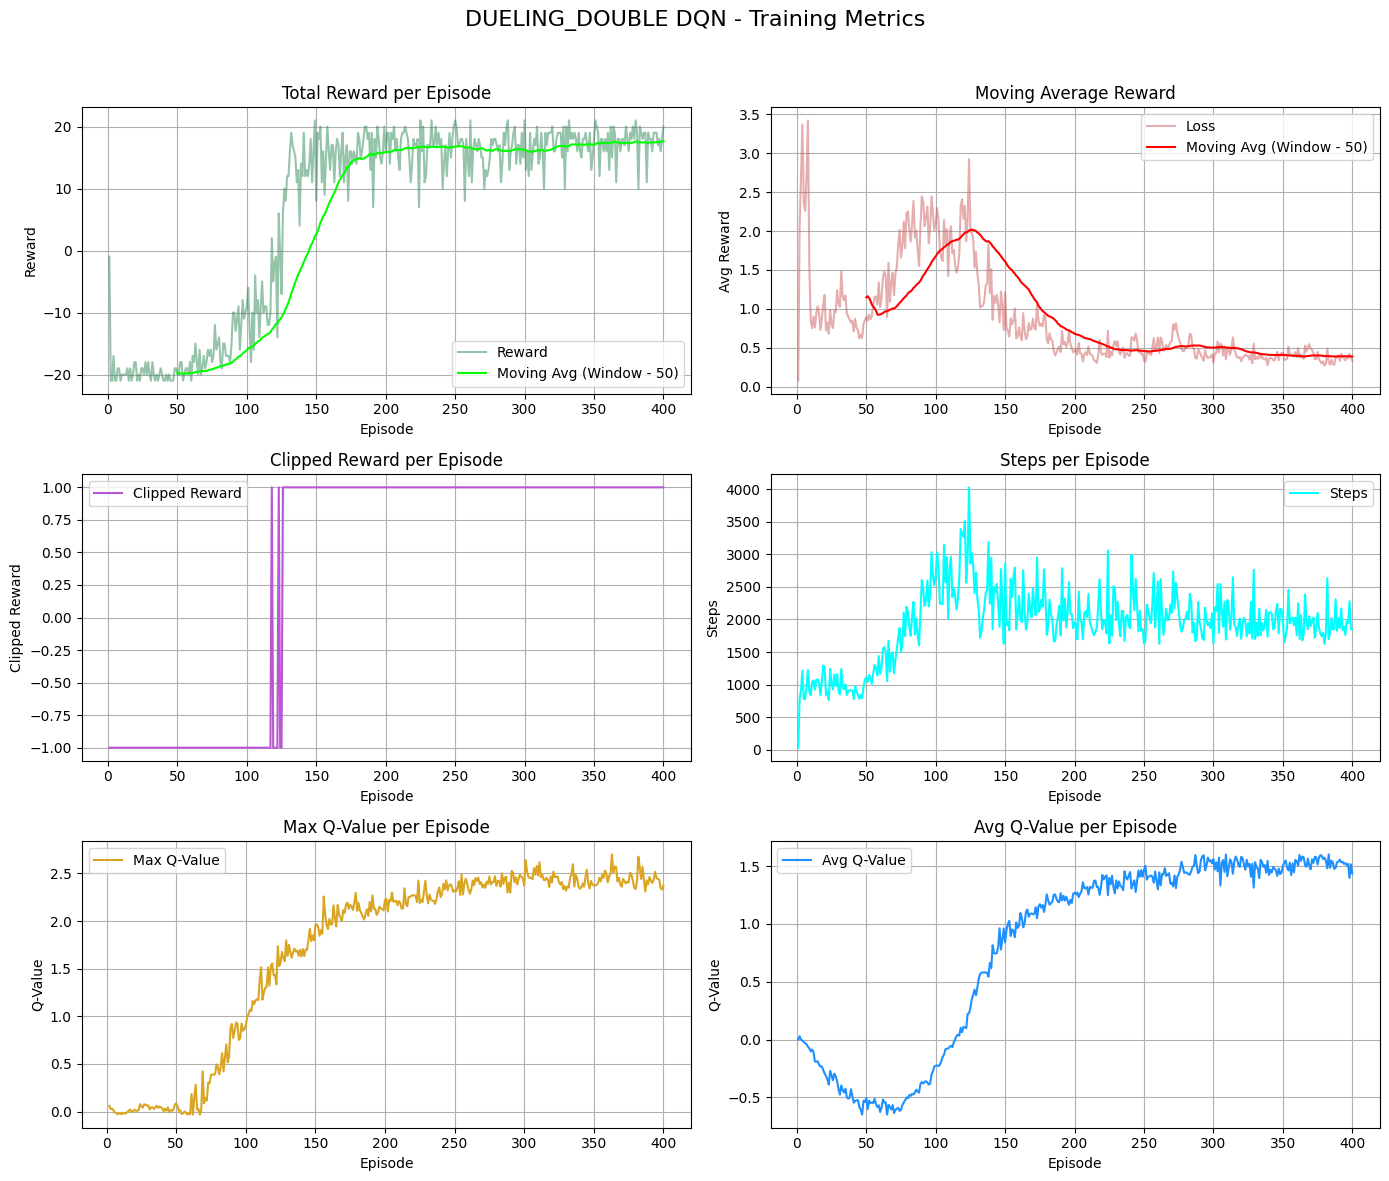

In [21]:
plot_performance_metrics(csv_file_path=ADDED_VALUE_TRAINING_METRICS_FILE_NAME, dqn_type='dueling_double')

##### b. Prioritised Experience Replay

In [22]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class PrioritizedReplayMemory(object):

    def __init__(self, capacity, alpha=0.6):
        """Initialize the memory buffer with priorities."""
        self.capacity = capacity
        self.memory = deque([], maxlen=capacity)
        self.priorities = deque([], maxlen=capacity)  # Store the priorities of transitions
        self.alpha = alpha  # The exponent for prioritization, usually between 0.5 and 1.0

    def push(self, *args):
        """Save a transition and its initial priority."""
        max_priority = max(self.priorities) if self.priorities else 0.99  # Initial priority is high
        self.memory.append(Transition(*args))
        self.priorities.append(max_priority)

    def sample(self, batch_size, beta=0.4):
        """Sample a batch of transitions with priority sampling."""
        # Convert priorities to probabilities (with alpha exponent)
        priorities = np.array(self.priorities) ** self.alpha
        probabilities = priorities / sum(priorities)

        # Sample indices based on the probability distribution
        indices = np.random.choice(len(self.memory), batch_size, p=probabilities)

        # Sample transitions and calculate importance-sampling weights
        batch = [self.memory[idx] for idx in indices]
        weights = (len(self.memory) * probabilities[indices]) ** (-beta)
        weights /= weights.max()  # Normalize weights for stability

        return batch, indices, weights

    def update_priorities(self, indices, priorities):
        """Update priorities of sampled transitions after TD error calculation."""
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = priority.item()

    def __len__(self):
        return len(self.memory)

In [23]:
class DQNAgentPER(DQNAgent):
    def __init__(
            self,
            env: gym.Env,
            replay_buffer: PrioritizedReplayMemory,
            lr: float,
            batch_size: int,
            device: str,
            is_double_dqn: bool = False
        ):
        """
        Initialize the DQN Agent.

        Args:
            env: The environment.
            replay_buffer: Prioritized Replay memory for storing transitions.
            lr: Learning rate.
            batch_size: Size of mini-batches sampled from replay buffer.
            device: 'cuda' or 'cpu'.
            is_double_dqn: Whether to use Double DQN for target computation.
        """
        self.env = env
        self.memory = replay_buffer
        self.batch_size = batch_size
        self.is_double_dqn = is_double_dqn

        self.policy_network = DuelingDQN(env.action_space.n).to(device)
        self.target_network = DuelingDQN(env.action_space.n).to(device)
        self.update_target_network()
        self.target_network.eval()

        self.optimizer = optim.AdamW(self.policy_network.parameters(), lr=lr, amsgrad=True)
        self.optimizer.zero_grad()

        self.device = device

    def optimise_td_loss(self, beta):
        """
        Optimize the TD error using a mini-batch of sampled transitions.
        Returns the loss value.
        """
        if len(self.memory) < self.batch_size:
            return

        transitions, indices, weights = self.memory.sample(batch_size=self.batch_size, beta=beta)
        batch = Transition(*zip(*transitions))

        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                    if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.policy_network(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1).values
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            if self.is_double_dqn:
                # Double DQN: Use policy_network to select action, target_network to evaluate it
                next_q_values = self.policy_network(non_final_next_states)
                best_actions = next_q_values.argmax(1, keepdim=True)  # Get best action indices
                target_q_values = self.target_network(non_final_next_states).gather(1, best_actions).squeeze(1)
                next_state_values[non_final_mask] = target_q_values
            else:
                # Standard DQN: Use target_network to directly compute max Q-values for next states
                next_state_values[non_final_mask] = self.target_network(non_final_next_states).max(1).values
        
        # Compute the expected Q values
        expected_state_action_values = (next_state_values * GAMMA) + reward_batch

        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        # Loss from Prioritized Experience Replay
        weights = torch.tensor(weights, dtype=loss.dtype, device=device)
        loss = (weights * loss).mean()
        self.memory.update_priorities(
            indices, 
            np.array(torch.abs(state_action_values-expected_state_action_values.unsqueeze(1)+1e-16).detach().cpu().numpy())
        )

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(self.policy_network.parameters(), 100)
        self.optimizer.step()

        return loss.item()

In [24]:
prioritized_replay_memory = PrioritizedReplayMemory(REPLAY_MEMORY_BUFFER_SIZE)
double_dqn_agent = DQNAgentPER(
        env=env,
        replay_buffer=prioritized_replay_memory,
        lr=LEARNING_RATE,
        batch_size=BATCH_SIZE,
        device=device,
        is_double_dqn=True
    )

d3qn_PER_episode_rewards = []
d3qn_PER_episode_losses = []
d3qn_PER_episode_max_q = []
d3qn_PER_episode_avg_q = []
d3qn_PER_steps_per_episode = []
d3qn_PER_clipped_episode_rewards = []

train_agent(
    double_dqn_agent,
    env,
    d3qn_PER_episode_rewards,
    d3qn_PER_episode_losses,
    d3qn_PER_episode_max_q,
    d3qn_PER_episode_avg_q,
    d3qn_PER_steps_per_episode,
    d3qn_PER_clipped_episode_rewards
    )

log_training_metrics_to_csv(
    ADDED_VALUE_TRAINING_METRICS_FILE_NAME,
    d3qn_PER_episode_rewards,
    d3qn_PER_episode_losses,
    d3qn_PER_episode_max_q,
    d3qn_PER_episode_avg_q,
    d3qn_PER_steps_per_episode,
    d3qn_PER_clipped_episode_rewards,
    dqn_type='d3qn_PER'
    )

[INFO] Replay memory pre-filled with 1000 transitions. Beginning training...

Episode 25/400 | Epsilon: 0.774 | Rewards this episode: {0: 1122, -1: 21, 1: 2} | Avg Reward (last 10): -19.70
Episode 50/400 | Epsilon: 0.553 | Rewards this episode: {0: 972, -1: 21, 1: 2} | Avg Reward (last 10): -20.20
Episode 75/400 | Epsilon: 0.269 | Rewards this episode: {0: 1502, -1: 21, 1: 4} | Avg Reward (last 10): -17.10
Episode 100/400 | Epsilon: 0.050 | Rewards this episode: {0: 2338, -1: 21, 1: 13} | Avg Reward (last 10): -7.20
Episode 125/400 | Epsilon: 0.050 | Rewards this episode: {0: 3296, -1: 15, 1: 21} | Avg Reward (last 10): 6.90
Episode 150/400 | Epsilon: 0.050 | Rewards this episode: {0: 1851, -1: 3, 1: 21} | Avg Reward (last 10): 13.70
Episode 175/400 | Epsilon: 0.050 | Rewards this episode: {0: 1874, -1: 4, 1: 21} | Avg Reward (last 10): 16.40
Episode 200/400 | Epsilon: 0.050 | Rewards this episode: {0: 1791, 1: 21, -1: 2} | Avg Reward (last 10): 18.40
Episode 225/400 | Epsilon: 0.050 |

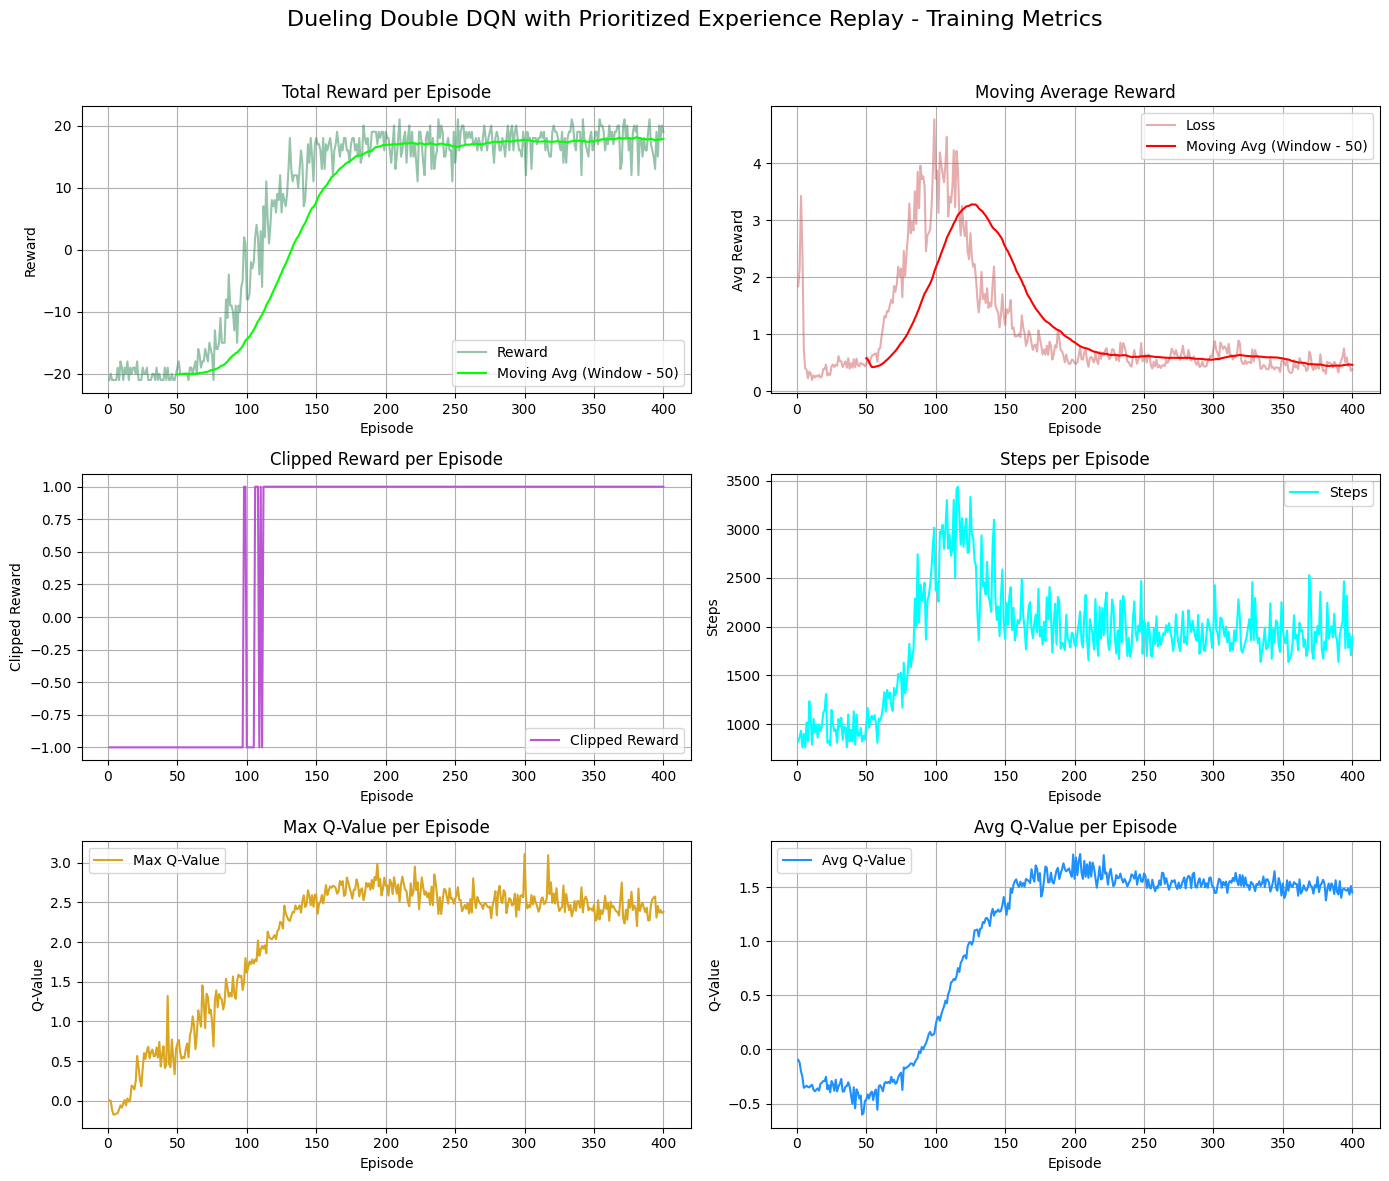

: 

In [ ]:
plot_performance_metrics(csv_file_path=ADDED_VALUE_TRAINING_METRICS_FILE_NAME, dqn_type='d3qn_PER')

##### c. Discussions in published papers or blogs from reputable sources that provide additional insight into the results

A key design choice in my implementation was the use of reward clipping to the range [−1,1][−1,1]. This technique is supported by the findings in the original DQN paper by Mnih et al. (2015), which reported that clipping rewards stabilizes learning across a wide range of Atari environments by preventing extreme gradient updates. While this introduces some loss of granularity in score feedback, it has been shown to lead to more robust learning, especially in games with sparse or highly variable reward structures like Breakout.

In addition, the use of a target network that is updated less frequently than the online (policy) network is also grounded in this paper. This method prevents feedback loops caused by rapidly changing Q-targets and was shown to be essential for stabilizing deep Q-learning.

Although I did not implement it, insights from Wang et al. (2016) suggest that using a Dueling DQN architecture could further improve learning in Breakout. Their work shows that separating the estimation of state value and action advantage leads to more stable learning and faster convergence, particularly in environments where the importance of actions varies across states. This could benefit scenarios in Breakout where, for example, certain paddle movements are irrelevant until the ball reaches a critical position.

Together, these insights from published research help justify the design choices made in my implementation and highlight possible extensions for future work.


[Rainbow: Combining Improvements in Deep Reinforcement Learning](https://arxiv.org/abs/1710.02298)
Noisy Networks

Problem Addressed: Traditional ε-greedy exploration methods — where the agent randomly selects actions based on an exploration parameter ε — can struggle to balance exploration and exploitation, particularly in environments like Breakout, where intelligent exploration is crucial. Random action selection can be inefficient, especially as the agent learns more about the environment.

Solution: Noisy Networks address this by injecting learnable noise into the weights of the neural network. Instead of relying on fixed or decaying randomness, Noisy Networks introduce stochasticity directly into the model's decision-making process, allowing the agent to adaptively explore the environment. The noise is learned during training, which helps the agent discover effective exploration strategies without the limitations of manually-tuned parameters.
Multi-Step Learning

Problem Addressed: In environments with delayed rewards, such as Breakout, the agent often has to wait several steps before seeing the outcome of its actions. Standard one-step learning methods can be inefficient because they only update Q-values based on the immediate reward, ignoring the future rewards that may follow a particular action.

Solution: Multi-step learning improves on this by considering rewards over multiple time steps. Instead of updating Q-values using only the immediate next reward (as in traditional Q-learning), multi-step learning aggregates rewards over several steps, making it more efficient at propagating reward signals across longer time horizons. This allows the agent to make more informed updates, especially in scenarios where actions leading to rewards unfold over multiple steps.